In [2]:
import os
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as nps
import matplotlib.pyplot as plt

In [3]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]


def unroll(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        l += [k for k in series[key]]
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (7.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (5.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (3.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (1.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def eval(pred, truth):
    o_pred = []
    o_truth = []
    f_pred = []
    f_truth = []
    b_pred = []
    b_truth = []
    s_pred = []
    s_truth = []
    l_pred = []
    l_truth = []
    for p in pred:
        o_pred.append(p[0])
        f_pred.append(p[1])
        b_pred.append(p[2])
        s_pred.append(p[3])
        l_pred.append(p[4])
    for t in truth:
        o_truth.append(t[0])
        f_truth.append(t[1])
        b_truth.append(t[2])
        s_truth.append(t[3])
        l_truth.append(t[4])
    return [[E0(o_pred, o_truth), E1(o_pred, o_truth), E2(o_pred, o_truth), E3(o_pred, o_truth)],
            [E0(f_pred, f_truth), E1(f_pred, f_truth), E2(f_pred, f_truth), E3(f_pred, f_truth)],
            [E0(b_pred, b_truth), E1(b_pred, b_truth), E2(b_pred, b_truth), E3(b_pred, b_truth)],
            [E0(s_pred, s_truth), E1(s_pred, s_truth), E2(s_pred, s_truth), E3(s_pred, s_truth)],
            [E0(l_pred, l_truth), E1(l_pred, l_truth), E2(l_pred, l_truth), E3(l_pred, l_truth)]]

In [4]:
# loading data

raw_X_train_list = []
smoothed_X_train_list = []
trans_X_train_list = []
final_X_train_list = []

y_train_list = []

raw_X_test_list = []
smoothed_X_test_list = []
trans_X_test_list = []
final_X_test_list = []

y_test_list = []

with open("..\\test_examples.txt") as t:
    test_examples = t.readlines()

for example in test_examples:
    raw_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\1_unprocessed\\" + example[:-1])
    smoothed_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\2_smoothed\\" + example[:-1])
    trans_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\3_translation\\" + example[:-1])
    final_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])

    raw_X_test_list.append(unroll(raw_series))
    smoothed_X_test_list.append(unroll(smoothed_series))
    trans_X_test_list.append(unroll(trans_series))
    final_X_test_list.append(unroll(final_series))
    
    y_test_list.append([float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9])

raw_X_test = torch.tensor(raw_X_test_list)
smoothed_X_test = torch.tensor(smoothed_X_test_list)
trans_X_test = torch.tensor(trans_X_test_list)
final_X_test = torch.tensor(final_X_test_list)


y_test = torch.tensor(y_test_list)

print(raw_X_test.size())
print(smoothed_X_test.size())
print(trans_X_test.size())
print(final_X_test.size())
print(y_test.size())
print('\n\n')

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

for example in training_examples:
    raw_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\1_unprocessed\\" + example[:-1])
    smoothed_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\2_smoothed\\" + example[:-1])
    trans_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\3_translation\\" + example[:-1])
    final_series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])

    raw_X_train_list.append(unroll(raw_series))
    smoothed_X_train_list.append(unroll(smoothed_series))
    trans_X_train_list.append(unroll(trans_series))
    final_X_train_list.append(unroll(final_series))
    
    y_train_list.append([float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9])

raw_X_train = torch.tensor(raw_X_train_list)
smoothed_X_train = torch.tensor(smoothed_X_train_list)
trans_X_train = torch.tensor(trans_X_train_list)
final_X_train = torch.tensor(final_X_train_list)

y_train = torch.tensor(y_train_list)

print(raw_X_train.size())
print(smoothed_X_train.size())
print(trans_X_train.size())
print(final_X_train.size())
print(y_train.size())

print(y_train)

print(raw_X_test)

torch.Size([93, 224])
torch.Size([93, 224])
torch.Size([93, 224])
torch.Size([93, 224])
torch.Size([93, 5])



torch.Size([371, 224])
torch.Size([371, 224])
torch.Size([371, 224])
torch.Size([371, 224])
torch.Size([371, 5])
tensor([[0.0000, 0.0000, 0.2222, 0.7778, 0.1111],
        [0.0000, 0.0000, 0.2222, 0.7778, 0.1111],
        [0.0000, 0.0000, 0.6667, 0.4444, 0.7778],
        ...,
        [0.7778, 0.0000, 0.0000, 0.8889, 0.0000],
        [0.8889, 0.0000, 0.6667, 0.4444, 0.1111],
        [0.8889, 0.0000, 0.6667, 0.4444, 0.1111]])
tensor([[-0.6362, -0.7887, -0.9187,  ..., -0.8851, -0.9042, -0.9479],
        [ 0.5670,  0.5559,  0.5561,  ..., -0.5672, -0.6465, -0.6624],
        [ 0.6785,  0.6841,  0.6924,  ..., -0.6331, -0.6389, -0.6554],
        ...,
        [-0.5933, -0.5858, -0.5948,  ..., -0.6796, -0.6788, -0.6436],
        [-1.5417, -1.3969, -1.2291,  ..., -0.9690, -0.8860, -0.7436],
        [ 0.6145,  0.6195,  0.6132,  ..., -0.4735, -0.4727, -0.4439]])


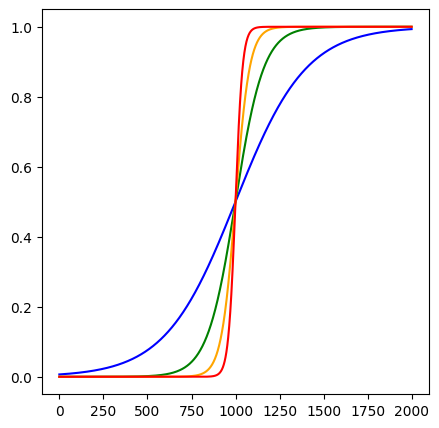

In [5]:
# testing tempered sigmoid

def temperedSigmoid(x, T):
    sigmoid = nn.Sigmoid()
    return sigmoid(T * x)

fig, ax = plt.subplots(1, figsize = (5, 5))

x = torch.tensor(np.linspace(-50, 50, num=2000))
ax.plot(temperedSigmoid(x, 0.1).tolist(), c='b')
ax.plot(temperedSigmoid(x, 0.25).tolist(), c='g')
ax.plot(temperedSigmoid(x, 0.5).tolist(), c='orange')
ax.plot(temperedSigmoid(x, 1).tolist(), c='r')

In [6]:
# setting up FCNN

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(1)
    

input_size = 224
hidden_layer_size_1 = 450
hidden_layer_size_2 = 400
hidden_layer_size_3 = 330
hidden_layer_size_4 = 250
hidden_layer_size_5 = 150
hidden_layer_size_6 = 50
output_size = 5
batch_size = 371
learning_rate = 0.001
tmp = 0.1

class FCNN(nn.Module):
    
    def __init__(self):
        super(FCNN, self).__init__()
        self.apply(init_weights)
        self.fc1 = nn.Linear(input_size, hidden_layer_size_1)
        self.fc2 = nn.Linear(hidden_layer_size_1, hidden_layer_size_2)
        self.fc3 = nn.Linear(hidden_layer_size_2, hidden_layer_size_3)
        self.fc4 = nn.Linear(hidden_layer_size_3, hidden_layer_size_4)
        self.fc5 = nn.Linear(hidden_layer_size_4, hidden_layer_size_5)
        self.fc6 = nn.Linear(hidden_layer_size_5, hidden_layer_size_6)
        self.fc7 = nn.Linear(hidden_layer_size_6, output_size)
        self.sigmoid = nn.Sigmoid()
        self.temperature = tmp

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc6(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc7(x), negative_slope=0.1)
        # print('PENULTIMATE LAYER: ' + str(x))
        x = self.sigmoid(x * self.temperature)
        return x


model = FCNN()

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

training_cycles = 20
num_epochs = 300

MSE: 0.05106160789728165
ERRORS: [[21.50537634408602, 67.74193548387096, 82.79569892473118, 90.3225806451613], [6.451612903225806, 67.74193548387096, 80.64516129032258, 94.6236559139785], [5.376344086021505, 23.655913978494624, 66.66666666666667, 88.17204301075269], [22.580645161290324, 53.763440860215056, 75.26881720430107, 89.24731182795699], [15.053763440860216, 69.89247311827957, 79.56989247311827, 91.39784946236558]]


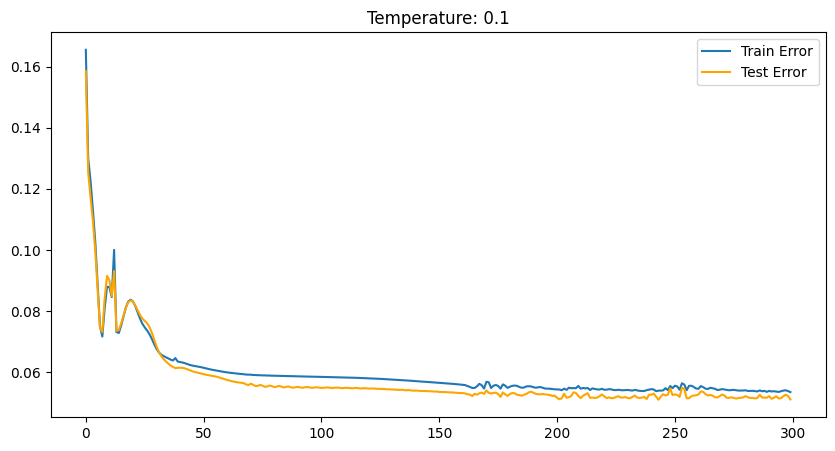

In [159]:
# training and evaluating raw series

min_loss = 1.0

errors = []

saved_test_losses = []
saved_train_losses = []

for i in range(training_cycles):
    model.apply(init_weights)
    test_losses = []
    train_losses = []
    for epoch in range(num_epochs):
        pred_y = model(raw_X_train)
        loss = loss_function(pred_y, y_train)
        train_losses.append(loss.item())

        test_y = model(raw_X_test)
        test_loss = loss_function(test_y, y_test)
        test_losses.append(test_loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()

    if (test_losses [-1] < min_loss):
        min_loss = test_losses[-1]
        test_y = model(raw_X_test)

        saved_test_losses = test_losses
        saved_train_losses = train_losses

        errors.clear()
        errors = eval(test_y, y_test.tolist()) 

print('MSE: ' + str(min_loss))
print('ERRORS: ' + str(errors))

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.set_title('Temperature: ' + str(model.temperature))
ax.plot(saved_train_losses, label='Train Error')
ax.plot(saved_test_losses, label='Test Error', c='orange')
ax.legend()

In [160]:
# training and evaluating smoothed series

min_loss = 100.0

errors = []

for i in range(training_cycles):
    model.apply(init_weights)
    test_losses = []
    for epoch in range(num_epochs):
        pred_y = model(smoothed_X_train)
        loss = loss_function(pred_y, y_train)

        test_y = model(smoothed_X_test)
        test_loss = loss_function(test_y, y_test)
        test_losses.append(test_loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()

    if (test_losses [-1] < min_loss):
        min_loss = test_losses[-1]
        test_y = model(smoothed_X_test)

        errors.clear()
        errors = eval(test_y, y_test.tolist())

print('MSE: ' + str(min_loss))
print('ERRORS: ' + str(errors))

MSE: 0.05110114440321922
ERRORS: [[22.580645161290324, 66.66666666666667, 82.79569892473118, 90.3225806451613], [5.376344086021505, 67.74193548387096, 83.87096774193549, 93.54838709677419], [6.451612903225806, 23.655913978494624, 66.66666666666667, 88.17204301075269], [20.43010752688172, 51.61290322580645, 77.41935483870968, 88.17204301075269], [15.053763440860216, 66.66666666666667, 78.49462365591398, 90.3225806451613]]


In [161]:
# training and evaluating trans series

min_loss = 100.0

errors = []

for i in range(training_cycles):
    model.apply(init_weights)
    test_losses = []
    for epoch in range(num_epochs):
        pred_y = model(trans_X_train)
        loss = loss_function(pred_y, y_train)

        test_y = model(trans_X_test)
        test_loss = loss_function(test_y, y_test)
        test_losses.append(test_loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()

    if (test_losses [-1] < min_loss):
        min_loss = test_losses[-1]
        test_y = model(trans_X_test)

        errors.clear()
        errors = eval(test_y, y_test.tolist())

print('MSE: ' + str(min_loss))
print('ERRORS: ' + str(errors))

MSE: 0.050558120012283325
ERRORS: [[18.27956989247312, 60.215053763440864, 80.64516129032258, 92.47311827956989], [32.25806451612903, 63.44086021505376, 78.49462365591398, 94.6236559139785], [5.376344086021505, 25.806451612903224, 63.44086021505376, 88.17204301075269], [15.053763440860216, 54.83870967741935, 79.56989247311827, 92.47311827956989], [17.204301075268816, 69.89247311827957, 84.94623655913979, 92.47311827956989]]


In [7]:
# training and evaluating final series

min_loss = 100.0

errors = []

for i in range(training_cycles):
    model.apply(init_weights)
    test_losses = []
    for epoch in range(num_epochs):
        pred_y = model(final_X_train)
        loss = loss_function(pred_y, y_train)

        test_y = model(final_X_test)
        test_loss = loss_function(test_y, y_test)
        test_losses.append(test_loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()

    if (test_losses [-1] < min_loss):
        min_loss = test_losses[-1]
        test_y = model(final_X_test)

        errors.clear()
        errors = eval(test_y, y_test.tolist())

print('MSE: ' + str(min_loss))
print('ERRORS: ' + str(errors))

MSE: 0.0417935848236084
ERRORS: [[19.35483870967742, 63.44086021505376, 74.19354838709677, 90.3225806451613], [18.27956989247312, 75.26881720430107, 92.47311827956989, 94.6236559139785], [15.053763440860216, 58.064516129032256, 81.72043010752688, 90.3225806451613], [22.580645161290324, 61.29032258064516, 84.94623655913979, 96.7741935483871], [27.956989247311828, 65.59139784946237, 81.72043010752688, 94.6236559139785]]
